In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

balanced_path_data = 'drive/MyDrive/balanced_csic_data_128/training'
imbalanced_path_data = 'drive/MyDrive/imbalanced_csic_data_128/training'

feature_extract = True

In [ ]:
mean = torch.tensor([135.31470632, 124.53849418, 103.39646082])
std = torch.tensor([5.18153318, 4.14170719, 5.17011963])

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# load the balanced dataset
balanced_dataset = datasets.ImageFolder(balanced_path_data, transform=transform)
balanced_datasets = train_val_dataset(balanced_dataset)

# #load the imbalanced dataset
# imbalanced_dataset = datasets.ImageFolder(imbalanced_path_data, transform=transform)
# imbalanced_datasets = train_val_dataset(imbalanced_dataset)

class_dict = balanced_dataset.class_to_idx

In [ ]:
batch_size = 32
balanced_dataloaders_dict = {x: torch.utils.data.DataLoader(balanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
#imbalanced_dataloaders_dict = {x: torch.utils.data.DataLoader(imbalanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [ ]:
# data_iter = iter(dataloaders_dict['train'])
# images, labels = next(data_iter)

In [ ]:
from tqdm import trange
from tqdm import tqdm

In [ ]:
# def getCategoricalAccuracy(pred, true, class_names:dict):
#   for cl in class_names.keys():
#     class_id = int(class_names[cl])
#     locs = np.where(np.array(true)==class_id)
#     class_acc = sum(pred[locs] == int(class_id))/len(locs)
#     print('Accuracy for {}:{}'.format(str(cl), class_acc))

def train_model(model, dataloaders, criterion, optimizer, num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                      if is_inception and phase == 'train':
                          # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                          outputs, aux_outputs = model(inputs)
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2
                      else:
                          outputs = model(inputs)
                          loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)
                      

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  #getCategoricalAccuracy(preds, labels.data, class_dict)
                  running_corrects += torch.sum(preds == labels.data)

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_acc)
              if phase == 'train':
                  train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model_ft_balanced = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ft_balanced, True)
model_ft_balanced.fc = nn.Linear(512, len(balanced_dataset.class_to_idx))
input_size = 224

model_ft_balanced = model_ft_balanced.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Setup the loss fxn
import time
import copy
criterion = nn.CrossEntropyLoss()
epoch = 50

# Train and evaluate - balanced
model_ft_balanced, balanced_val_hist, balanced_tr_hist  = train_model(model_ft_balanced, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.84batch/s]


train Loss: 0.9913 Acc: 0.6727


100%|██████████| 5/5 [00:00<00:00,  7.65batch/s]


val Loss: 0.9902 Acc: 0.6486

Epoch 1/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.90batch/s]


train Loss: 0.9195 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  7.68batch/s]


val Loss: 0.9888 Acc: 0.6486

Epoch 2/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.03batch/s]


train Loss: 0.9112 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  7.91batch/s]


val Loss: 0.9868 Acc: 0.6486

Epoch 3/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.12batch/s]


train Loss: 0.9061 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  8.03batch/s]


val Loss: 0.9829 Acc: 0.6486

Epoch 4/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.93batch/s]


train Loss: 0.8998 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  8.14batch/s]


val Loss: 0.9804 Acc: 0.6486

Epoch 5/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.92batch/s]


train Loss: 0.8950 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  8.11batch/s]


val Loss: 0.9743 Acc: 0.6486

Epoch 6/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.06batch/s]


train Loss: 0.8900 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  7.91batch/s]


val Loss: 0.9695 Acc: 0.6486

Epoch 7/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.94batch/s]


train Loss: 0.8840 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.92batch/s]


val Loss: 0.9646 Acc: 0.6486

Epoch 8/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.82batch/s]


train Loss: 0.8772 Acc: 0.6772


100%|██████████| 5/5 [00:00<00:00,  7.85batch/s]


val Loss: 0.9636 Acc: 0.6486

Epoch 9/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.88batch/s]


train Loss: 0.8728 Acc: 0.6840


100%|██████████| 5/5 [00:00<00:00,  7.87batch/s]


val Loss: 0.9597 Acc: 0.6486

Epoch 10/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.93batch/s]


train Loss: 0.8715 Acc: 0.6840


100%|██████████| 5/5 [00:00<00:00,  8.04batch/s]


val Loss: 0.9542 Acc: 0.6419

Epoch 11/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.91batch/s]


train Loss: 0.8673 Acc: 0.6833


100%|██████████| 5/5 [00:00<00:00,  7.92batch/s]


val Loss: 0.9522 Acc: 0.6351

Epoch 12/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.96batch/s]


train Loss: 0.8640 Acc: 0.6870


100%|██████████| 5/5 [00:00<00:00,  7.94batch/s]


val Loss: 0.9541 Acc: 0.6419

Epoch 13/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.93batch/s]


train Loss: 0.8579 Acc: 0.6855


100%|██████████| 5/5 [00:00<00:00,  8.02batch/s]


val Loss: 0.9488 Acc: 0.6284

Epoch 14/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.8574 Acc: 0.6878


100%|██████████| 5/5 [00:00<00:00,  7.80batch/s]


val Loss: 0.9438 Acc: 0.6284

Epoch 15/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.90batch/s]


train Loss: 0.8563 Acc: 0.6840


100%|██████████| 5/5 [00:00<00:00,  7.95batch/s]


val Loss: 0.9388 Acc: 0.6419

Epoch 16/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.99batch/s]


train Loss: 0.8514 Acc: 0.6878


100%|██████████| 5/5 [00:00<00:00,  7.93batch/s]


val Loss: 0.9392 Acc: 0.6284

Epoch 17/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.8479 Acc: 0.6893


100%|██████████| 5/5 [00:00<00:00,  8.07batch/s]


val Loss: 0.9344 Acc: 0.6419

Epoch 18/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.97batch/s]


train Loss: 0.8391 Acc: 0.6870


100%|██████████| 5/5 [00:00<00:00,  7.93batch/s]


val Loss: 0.9281 Acc: 0.6284

Epoch 19/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.8410 Acc: 0.6878


100%|██████████| 5/5 [00:00<00:00,  8.09batch/s]


val Loss: 0.9264 Acc: 0.6284

Epoch 20/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.98batch/s]


train Loss: 0.8367 Acc: 0.6893


100%|██████████| 5/5 [00:00<00:00,  7.86batch/s]


val Loss: 0.9261 Acc: 0.6284

Epoch 21/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.82batch/s]


train Loss: 0.8351 Acc: 0.6908


100%|██████████| 5/5 [00:00<00:00,  7.96batch/s]


val Loss: 0.9243 Acc: 0.6351

Epoch 22/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.80batch/s]


train Loss: 0.8295 Acc: 0.6885


100%|██████████| 5/5 [00:00<00:00,  7.99batch/s]


val Loss: 0.9187 Acc: 0.6284

Epoch 23/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.93batch/s]


train Loss: 0.8288 Acc: 0.6863


100%|██████████| 5/5 [00:00<00:00,  7.86batch/s]


val Loss: 0.9207 Acc: 0.6284

Epoch 24/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.00batch/s]


train Loss: 0.8263 Acc: 0.6916


100%|██████████| 5/5 [00:00<00:00,  7.81batch/s]


val Loss: 0.9136 Acc: 0.6284

Epoch 25/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.92batch/s]


train Loss: 0.8242 Acc: 0.6863


100%|██████████| 5/5 [00:00<00:00,  7.93batch/s]


val Loss: 0.9121 Acc: 0.6284

Epoch 26/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.8236 Acc: 0.6900


100%|██████████| 5/5 [00:00<00:00,  7.87batch/s]


val Loss: 0.9117 Acc: 0.6284

Epoch 27/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.83batch/s]


train Loss: 0.8200 Acc: 0.6885


100%|██████████| 5/5 [00:00<00:00,  7.84batch/s]


val Loss: 0.9062 Acc: 0.6284

Epoch 28/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.92batch/s]


train Loss: 0.8163 Acc: 0.6908


100%|██████████| 5/5 [00:00<00:00,  7.72batch/s]


val Loss: 0.9046 Acc: 0.6284

Epoch 29/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.04batch/s]


train Loss: 0.8138 Acc: 0.6885


100%|██████████| 5/5 [00:00<00:00,  7.71batch/s]


val Loss: 0.9013 Acc: 0.6284

Epoch 30/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.8120 Acc: 0.6878


100%|██████████| 5/5 [00:00<00:00,  7.47batch/s]


val Loss: 0.8995 Acc: 0.6419

Epoch 31/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.96batch/s]


train Loss: 0.8101 Acc: 0.6908


100%|██████████| 5/5 [00:00<00:00,  7.91batch/s]


val Loss: 0.8968 Acc: 0.6419

Epoch 32/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.83batch/s]


train Loss: 0.8084 Acc: 0.6885


100%|██████████| 5/5 [00:00<00:00,  8.00batch/s]


val Loss: 0.8965 Acc: 0.6419

Epoch 33/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.76batch/s]


train Loss: 0.8023 Acc: 0.6946


100%|██████████| 5/5 [00:00<00:00,  7.85batch/s]


val Loss: 0.8920 Acc: 0.6419

Epoch 34/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.88batch/s]


train Loss: 0.7962 Acc: 0.6983


100%|██████████| 5/5 [00:00<00:00,  7.97batch/s]


val Loss: 0.9025 Acc: 0.6284

Epoch 35/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.84batch/s]


train Loss: 0.8042 Acc: 0.6923


100%|██████████| 5/5 [00:00<00:00,  7.82batch/s]


val Loss: 0.8905 Acc: 0.6351

Epoch 36/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.75batch/s]


train Loss: 0.7983 Acc: 0.6931


100%|██████████| 5/5 [00:00<00:00,  7.93batch/s]


val Loss: 0.8862 Acc: 0.6419

Epoch 37/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.85batch/s]


train Loss: 0.7964 Acc: 0.6931


100%|██████████| 5/5 [00:00<00:00,  8.07batch/s]


val Loss: 0.8867 Acc: 0.6419

Epoch 38/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.85batch/s]


train Loss: 0.7932 Acc: 0.6946


100%|██████████| 5/5 [00:00<00:00,  8.02batch/s]


val Loss: 0.8812 Acc: 0.6419

Epoch 39/49
----------


100%|██████████| 42/42 [00:04<00:00, 10.00batch/s]


train Loss: 0.7916 Acc: 0.6946


100%|██████████| 5/5 [00:00<00:00,  7.62batch/s]


val Loss: 0.8835 Acc: 0.6419

Epoch 40/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.94batch/s]


train Loss: 0.7886 Acc: 0.6976


100%|██████████| 5/5 [00:00<00:00,  8.08batch/s]


val Loss: 0.8793 Acc: 0.6419

Epoch 41/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.98batch/s]


train Loss: 0.7876 Acc: 0.6961


100%|██████████| 5/5 [00:00<00:00,  8.07batch/s]


val Loss: 0.8803 Acc: 0.6419

Epoch 42/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.97batch/s]


train Loss: 0.7877 Acc: 0.6976


100%|██████████| 5/5 [00:00<00:00,  8.07batch/s]


val Loss: 0.8789 Acc: 0.6419

Epoch 43/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.7860 Acc: 0.6961


100%|██████████| 5/5 [00:00<00:00,  7.94batch/s]


val Loss: 0.8725 Acc: 0.6419

Epoch 44/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.90batch/s]


train Loss: 0.7801 Acc: 0.6953


100%|██████████| 5/5 [00:00<00:00,  7.97batch/s]


val Loss: 0.8713 Acc: 0.6419

Epoch 45/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.97batch/s]


train Loss: 0.7824 Acc: 0.6983


100%|██████████| 5/5 [00:00<00:00,  7.81batch/s]


val Loss: 0.8702 Acc: 0.6419

Epoch 46/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.84batch/s]


train Loss: 0.7784 Acc: 0.6938


100%|██████████| 5/5 [00:00<00:00,  7.97batch/s]


val Loss: 0.8700 Acc: 0.6419

Epoch 47/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.63batch/s]


train Loss: 0.7768 Acc: 0.6991


100%|██████████| 5/5 [00:00<00:00,  7.78batch/s]


val Loss: 0.8698 Acc: 0.6419

Epoch 48/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.95batch/s]


train Loss: 0.7740 Acc: 0.6991


100%|██████████| 5/5 [00:00<00:00,  7.99batch/s]


val Loss: 0.8648 Acc: 0.6622

Epoch 49/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.98batch/s]


train Loss: 0.7699 Acc: 0.7036


100%|██████████| 5/5 [00:00<00:00,  7.93batch/s]

val Loss: 0.8655 Acc: 0.6419

Training complete in 4m 7s
Best val Acc: 0.662162


In [ ]:
# model_ft_imbalanced = models.resnet18(pretrained=True)
# set_parameter_requires_grad(model_ft_imbalanced, True)
# model_ft_imbalanced.fc = nn.Linear(512, len(class_dict))
# input_size = 224

# model_ft_imbalanced = model_ft_imbalanced.to(device)

# # Gather the parameters to be optimized/updated in this run. If we are
# #  finetuning we will be updating all parameters. However, if we are
# #  doing feature extract method, we will only update the parameters
# #  that we have just initialized, i.e. the parameters with requires_grad
# #  is True.
# params_to_update = model_ft_imbalanced.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft_imbalanced.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft_imbalanced.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params_to_update, lr=0.00001)
# Train and evaluate - imbalanced
# model_ft_imbalanced, imbalanced_val_hist, imbalanced_tr_hist  = train_model(model_ft_imbalanced, imbalanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

In [ ]:
#ResNet 50
model_ft_balanced2 = models.resnet50(pretrained=True)
set_parameter_requires_grad(model_ft_balanced2, True)
model_ft_balanced2.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced2 = model_ft_balanced2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced2, balanced_val_hist2, balanced_tr_hist2  = train_model(model_ft_balanced2, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.06batch/s]


train Loss: 0.9761 Acc: 0.6531


100%|██████████| 5/5 [00:00<00:00,  6.98batch/s]


val Loss: 1.2217 Acc: 0.6486

Epoch 1/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.19batch/s]


train Loss: 0.9054 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  7.14batch/s]


val Loss: 0.9755 Acc: 0.6486

Epoch 2/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.95batch/s]


train Loss: 0.8864 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  7.01batch/s]


val Loss: 0.9380 Acc: 0.6486

Epoch 3/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.08batch/s]


train Loss: 0.8651 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  6.94batch/s]


val Loss: 0.9305 Acc: 0.6486

Epoch 4/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.02batch/s]


train Loss: 0.8471 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  7.17batch/s]


val Loss: 0.9174 Acc: 0.6486

Epoch 5/49
----------


100%|██████████| 42/42 [00:04<00:00,  9.06batch/s]


train Loss: 0.8338 Acc: 0.6817


100%|██████████| 5/5 [00:00<00:00,  7.42batch/s]


val Loss: 0.9101 Acc: 0.6554

Epoch 6/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.88batch/s]


train Loss: 0.8202 Acc: 0.6840


100%|██████████| 5/5 [00:00<00:00,  7.00batch/s]


val Loss: 0.8962 Acc: 0.6689

Epoch 7/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.83batch/s]


train Loss: 0.8099 Acc: 0.6946


100%|██████████| 5/5 [00:00<00:00,  6.70batch/s]


val Loss: 0.8835 Acc: 0.6689

Epoch 8/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.71batch/s]


train Loss: 0.7882 Acc: 0.6916


100%|██████████| 5/5 [00:00<00:00,  7.21batch/s]


val Loss: 0.8776 Acc: 0.6554

Epoch 9/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.69batch/s]


train Loss: 0.7832 Acc: 0.7036


100%|██████████| 5/5 [00:00<00:00,  7.06batch/s]


val Loss: 0.8718 Acc: 0.6689

Epoch 10/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.66batch/s]


train Loss: 0.7753 Acc: 0.7089


100%|██████████| 5/5 [00:00<00:00,  6.88batch/s]


val Loss: 0.8618 Acc: 0.6554

Epoch 11/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.65batch/s]


train Loss: 0.7649 Acc: 0.7081


100%|██████████| 5/5 [00:00<00:00,  6.92batch/s]


val Loss: 0.8556 Acc: 0.6554

Epoch 12/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.61batch/s]


train Loss: 0.7532 Acc: 0.7074


100%|██████████| 5/5 [00:00<00:00,  6.96batch/s]


val Loss: 0.8436 Acc: 0.6689

Epoch 13/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.60batch/s]


train Loss: 0.7508 Acc: 0.7134


100%|██████████| 5/5 [00:00<00:00,  6.61batch/s]


val Loss: 0.8409 Acc: 0.6689

Epoch 14/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.52batch/s]


train Loss: 0.7354 Acc: 0.7157


100%|██████████| 5/5 [00:00<00:00,  6.98batch/s]


val Loss: 0.8348 Acc: 0.6757

Epoch 15/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.47batch/s]


train Loss: 0.7329 Acc: 0.7157


100%|██████████| 5/5 [00:00<00:00,  6.89batch/s]


val Loss: 0.8269 Acc: 0.6757

Epoch 16/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.53batch/s]


train Loss: 0.7249 Acc: 0.7285


100%|██████████| 5/5 [00:00<00:00,  6.99batch/s]


val Loss: 0.8294 Acc: 0.6622

Epoch 17/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.40batch/s]


train Loss: 0.7125 Acc: 0.7293


100%|██████████| 5/5 [00:00<00:00,  6.61batch/s]


val Loss: 0.8111 Acc: 0.6892

Epoch 18/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.43batch/s]


train Loss: 0.7132 Acc: 0.7262


100%|██████████| 5/5 [00:00<00:00,  6.80batch/s]


val Loss: 0.8065 Acc: 0.6824

Epoch 19/49
----------


100%|██████████| 42/42 [00:04<00:00,  8.49batch/s]


train Loss: 0.7065 Acc: 0.7217


100%|██████████| 5/5 [00:00<00:00,  6.64batch/s]


val Loss: 0.8067 Acc: 0.6959

Epoch 20/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.37batch/s]


train Loss: 0.7017 Acc: 0.7315


100%|██████████| 5/5 [00:00<00:00,  6.55batch/s]


val Loss: 0.7982 Acc: 0.6892

Epoch 21/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.38batch/s]


train Loss: 0.6953 Acc: 0.7345


100%|██████████| 5/5 [00:00<00:00,  6.60batch/s]


val Loss: 0.8088 Acc: 0.6689

Epoch 22/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.32batch/s]


train Loss: 0.6903 Acc: 0.7330


100%|██████████| 5/5 [00:00<00:00,  7.07batch/s]


val Loss: 0.7923 Acc: 0.6959

Epoch 23/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.35batch/s]


train Loss: 0.6825 Acc: 0.7353


100%|██████████| 5/5 [00:00<00:00,  6.69batch/s]


val Loss: 0.7915 Acc: 0.6892

Epoch 24/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.28batch/s]


train Loss: 0.6781 Acc: 0.7338


100%|██████████| 5/5 [00:00<00:00,  6.58batch/s]


val Loss: 0.7867 Acc: 0.7027

Epoch 25/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.33batch/s]


train Loss: 0.6751 Acc: 0.7383


100%|██████████| 5/5 [00:00<00:00,  6.48batch/s]


val Loss: 0.7786 Acc: 0.7095

Epoch 26/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.34batch/s]


train Loss: 0.6738 Acc: 0.7368


100%|██████████| 5/5 [00:00<00:00,  6.80batch/s]


val Loss: 0.7915 Acc: 0.6824

Epoch 27/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.27batch/s]


train Loss: 0.6687 Acc: 0.7383


100%|██████████| 5/5 [00:00<00:00,  6.67batch/s]


val Loss: 0.7720 Acc: 0.7095

Epoch 28/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.26batch/s]


train Loss: 0.6649 Acc: 0.7436


100%|██████████| 5/5 [00:00<00:00,  6.46batch/s]


val Loss: 0.7654 Acc: 0.7027

Epoch 29/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.18batch/s]


train Loss: 0.6536 Acc: 0.7526


100%|██████████| 5/5 [00:00<00:00,  6.82batch/s]


val Loss: 0.7691 Acc: 0.7095

Epoch 30/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.60batch/s]


train Loss: 0.6537 Acc: 0.7428


100%|██████████| 5/5 [00:01<00:00,  4.86batch/s]


val Loss: 0.7634 Acc: 0.7095

Epoch 31/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.35batch/s]


train Loss: 0.6507 Acc: 0.7519


100%|██████████| 5/5 [00:01<00:00,  3.95batch/s]


val Loss: 0.7649 Acc: 0.6959

Epoch 32/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.11batch/s]


train Loss: 0.6456 Acc: 0.7443


100%|██████████| 5/5 [00:00<00:00,  6.68batch/s]


val Loss: 0.7580 Acc: 0.6959

Epoch 33/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.09batch/s]


train Loss: 0.6407 Acc: 0.7579


100%|██████████| 5/5 [00:00<00:00,  6.57batch/s]


val Loss: 0.7587 Acc: 0.7095

Epoch 34/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.06batch/s]


train Loss: 0.6345 Acc: 0.7481


100%|██████████| 5/5 [00:00<00:00,  6.33batch/s]


val Loss: 0.7513 Acc: 0.7027

Epoch 35/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.14batch/s]


train Loss: 0.6386 Acc: 0.7421


100%|██████████| 5/5 [00:00<00:00,  5.66batch/s]


val Loss: 0.7506 Acc: 0.7027

Epoch 36/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.19batch/s]


train Loss: 0.6302 Acc: 0.7489


100%|██████████| 5/5 [00:00<00:00,  6.36batch/s]


val Loss: 0.7520 Acc: 0.7095

Epoch 37/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.04batch/s]


train Loss: 0.6316 Acc: 0.7481


100%|██████████| 5/5 [00:00<00:00,  5.54batch/s]


val Loss: 0.7727 Acc: 0.6757

Epoch 38/49
----------


100%|██████████| 42/42 [00:07<00:00,  5.75batch/s]


train Loss: 0.6248 Acc: 0.7504


100%|██████████| 5/5 [00:01<00:00,  4.89batch/s]


val Loss: 0.7406 Acc: 0.7027

Epoch 39/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.86batch/s]


train Loss: 0.6143 Acc: 0.7579


100%|██████████| 5/5 [00:00<00:00,  6.93batch/s]


val Loss: 0.7380 Acc: 0.6959

Epoch 40/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.08batch/s]


train Loss: 0.6181 Acc: 0.7534


100%|██████████| 5/5 [00:00<00:00,  6.74batch/s]


val Loss: 0.7359 Acc: 0.6959

Epoch 41/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.08batch/s]


train Loss: 0.6124 Acc: 0.7534


100%|██████████| 5/5 [00:00<00:00,  6.52batch/s]


val Loss: 0.7404 Acc: 0.6959

Epoch 42/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.11batch/s]


train Loss: 0.6129 Acc: 0.7587


100%|██████████| 5/5 [00:00<00:00,  6.31batch/s]


val Loss: 0.7330 Acc: 0.6959

Epoch 43/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.84batch/s]


train Loss: 0.6112 Acc: 0.7632


100%|██████████| 5/5 [00:00<00:00,  6.18batch/s]


val Loss: 0.7391 Acc: 0.7095

Epoch 44/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.06batch/s]


train Loss: 0.6102 Acc: 0.7572


100%|██████████| 5/5 [00:00<00:00,  5.95batch/s]


val Loss: 0.7426 Acc: 0.7027

Epoch 45/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.19batch/s]


train Loss: 0.5955 Acc: 0.7655


100%|██████████| 5/5 [00:00<00:00,  6.31batch/s]


val Loss: 0.7344 Acc: 0.6959

Epoch 46/49
----------


100%|██████████| 42/42 [00:05<00:00,  8.12batch/s]


train Loss: 0.5972 Acc: 0.7707


100%|██████████| 5/5 [00:00<00:00,  6.32batch/s]


val Loss: 0.7364 Acc: 0.6892

Epoch 47/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.90batch/s]


train Loss: 0.5956 Acc: 0.7700


100%|██████████| 5/5 [00:00<00:00,  6.57batch/s]


val Loss: 0.7257 Acc: 0.7095

Epoch 48/49
----------


100%|██████████| 42/42 [00:05<00:00,  7.80batch/s]


train Loss: 0.5912 Acc: 0.7707


100%|██████████| 5/5 [00:00<00:00,  6.90batch/s]


val Loss: 0.7268 Acc: 0.6959

Epoch 49/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.77batch/s]


train Loss: 0.5945 Acc: 0.7715


100%|██████████| 5/5 [00:01<00:00,  4.50batch/s]


val Loss: 0.7270 Acc: 0.7162

Training complete in 4m 59s
Best val Acc: 0.716216


In [ ]:
#ResNet 152
model_ft_balanced3 = models.resnet152(pretrained=True)
set_parameter_requires_grad(model_ft_balanced3, True)
model_ft_balanced3.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced3 = model_ft_balanced3.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced3.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced3, balanced_val_hist3, balanced_tr_hist3  = train_model(model_ft_balanced3, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.68batch/s]


train Loss: 1.0371 Acc: 0.5973


100%|██████████| 5/5 [00:01<00:00,  4.89batch/s]


val Loss: 7.3860 Acc: 0.6486

Epoch 1/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.70batch/s]


train Loss: 0.9026 Acc: 0.6757


100%|██████████| 5/5 [00:01<00:00,  4.90batch/s]


val Loss: 0.9274 Acc: 0.6486

Epoch 2/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.57batch/s]


train Loss: 0.8710 Acc: 0.6757


100%|██████████| 5/5 [00:01<00:00,  4.91batch/s]


val Loss: 0.9130 Acc: 0.6486

Epoch 3/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.28batch/s]


train Loss: 0.8455 Acc: 0.6757


100%|██████████| 5/5 [00:00<00:00,  5.30batch/s]


val Loss: 0.8927 Acc: 0.6486

Epoch 4/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.65batch/s]


train Loss: 0.8277 Acc: 0.6765


100%|██████████| 5/5 [00:00<00:00,  5.15batch/s]


val Loss: 0.8851 Acc: 0.6486

Epoch 5/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.59batch/s]


train Loss: 0.8183 Acc: 0.6802


100%|██████████| 5/5 [00:01<00:00,  4.96batch/s]


val Loss: 0.8606 Acc: 0.6486

Epoch 6/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.51batch/s]


train Loss: 0.7892 Acc: 0.6833


100%|██████████| 5/5 [00:01<00:00,  4.90batch/s]


val Loss: 0.8419 Acc: 0.6486

Epoch 7/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.57batch/s]


train Loss: 0.7793 Acc: 0.6923


100%|██████████| 5/5 [00:01<00:00,  4.92batch/s]


val Loss: 0.8203 Acc: 0.6486

Epoch 8/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.62batch/s]


train Loss: 0.7579 Acc: 0.6983


100%|██████████| 5/5 [00:01<00:00,  4.99batch/s]


val Loss: 0.8085 Acc: 0.6622

Epoch 9/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.60batch/s]


train Loss: 0.7427 Acc: 0.7074


100%|██████████| 5/5 [00:01<00:00,  4.90batch/s]


val Loss: 0.8001 Acc: 0.6757

Epoch 10/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.56batch/s]


train Loss: 0.7319 Acc: 0.7164


100%|██████████| 5/5 [00:01<00:00,  4.84batch/s]


val Loss: 0.7903 Acc: 0.6892

Epoch 11/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.53batch/s]


train Loss: 0.7215 Acc: 0.7187


100%|██████████| 5/5 [00:00<00:00,  5.19batch/s]


val Loss: 0.7797 Acc: 0.7095

Epoch 12/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.77batch/s]


train Loss: 0.7096 Acc: 0.7293


100%|██████████| 5/5 [00:00<00:00,  5.30batch/s]


val Loss: 0.7725 Acc: 0.6959

Epoch 13/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.91batch/s]


train Loss: 0.6970 Acc: 0.7353


100%|██████████| 5/5 [00:00<00:00,  5.14batch/s]


val Loss: 0.7564 Acc: 0.7095

Epoch 14/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.86batch/s]


train Loss: 0.6879 Acc: 0.7300


100%|██████████| 5/5 [00:00<00:00,  5.18batch/s]


val Loss: 0.7504 Acc: 0.6959

Epoch 15/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.89batch/s]


train Loss: 0.6803 Acc: 0.7474


100%|██████████| 5/5 [00:00<00:00,  5.34batch/s]


val Loss: 0.7535 Acc: 0.6959

Epoch 16/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.91batch/s]


train Loss: 0.6752 Acc: 0.7647


100%|██████████| 5/5 [00:00<00:00,  5.20batch/s]


val Loss: 0.7422 Acc: 0.7095

Epoch 17/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.80batch/s]


train Loss: 0.6637 Acc: 0.7481


100%|██████████| 5/5 [00:00<00:00,  5.49batch/s]


val Loss: 0.7323 Acc: 0.7095

Epoch 18/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.55batch/s]


train Loss: 0.6556 Acc: 0.7549


100%|██████████| 5/5 [00:00<00:00,  5.33batch/s]


val Loss: 0.7188 Acc: 0.7027

Epoch 19/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.89batch/s]


train Loss: 0.6494 Acc: 0.7594


100%|██████████| 5/5 [00:00<00:00,  5.42batch/s]


val Loss: 0.7216 Acc: 0.7162

Epoch 20/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.90batch/s]


train Loss: 0.6429 Acc: 0.7670


100%|██████████| 5/5 [00:00<00:00,  5.26batch/s]


val Loss: 0.7137 Acc: 0.7162

Epoch 21/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.85batch/s]


train Loss: 0.6407 Acc: 0.7602


100%|██████████| 5/5 [00:00<00:00,  5.34batch/s]


val Loss: 0.7089 Acc: 0.7297

Epoch 22/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.90batch/s]


train Loss: 0.6315 Acc: 0.7655


100%|██████████| 5/5 [00:00<00:00,  5.26batch/s]


val Loss: 0.6974 Acc: 0.7230

Epoch 23/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.85batch/s]


train Loss: 0.6234 Acc: 0.7707


100%|██████████| 5/5 [00:00<00:00,  5.28batch/s]


val Loss: 0.6952 Acc: 0.7095

Epoch 24/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.82batch/s]


train Loss: 0.6244 Acc: 0.7730


100%|██████████| 5/5 [00:00<00:00,  5.26batch/s]


val Loss: 0.6928 Acc: 0.7095

Epoch 25/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.83batch/s]


train Loss: 0.6218 Acc: 0.7707


100%|██████████| 5/5 [00:00<00:00,  5.23batch/s]


val Loss: 0.6971 Acc: 0.7162

Epoch 26/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.83batch/s]


train Loss: 0.6056 Acc: 0.7790


100%|██████████| 5/5 [00:00<00:00,  5.26batch/s]


val Loss: 0.6856 Acc: 0.6959

Epoch 27/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.89batch/s]


train Loss: 0.5996 Acc: 0.7790


100%|██████████| 5/5 [00:00<00:00,  5.15batch/s]


val Loss: 0.6780 Acc: 0.7230

Epoch 28/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.86batch/s]


train Loss: 0.6023 Acc: 0.7783


100%|██████████| 5/5 [00:00<00:00,  5.23batch/s]


val Loss: 0.6631 Acc: 0.7297

Epoch 29/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.91batch/s]


train Loss: 0.5969 Acc: 0.7881


100%|██████████| 5/5 [00:00<00:00,  5.23batch/s]


val Loss: 0.6824 Acc: 0.6892

Epoch 30/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.83batch/s]


train Loss: 0.6020 Acc: 0.7805


100%|██████████| 5/5 [00:00<00:00,  5.30batch/s]


val Loss: 0.6712 Acc: 0.7297

Epoch 31/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.84batch/s]


train Loss: 0.5971 Acc: 0.7707


100%|██████████| 5/5 [00:00<00:00,  5.26batch/s]


val Loss: 0.6626 Acc: 0.7230

Epoch 32/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.88batch/s]


train Loss: 0.5835 Acc: 0.7821


100%|██████████| 5/5 [00:00<00:00,  5.28batch/s]


val Loss: 0.6584 Acc: 0.7297

Epoch 33/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.53batch/s]


train Loss: 0.5837 Acc: 0.7813


100%|██████████| 5/5 [00:00<00:00,  5.24batch/s]


val Loss: 0.6496 Acc: 0.7297

Epoch 34/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.81batch/s]


train Loss: 0.5811 Acc: 0.7903


100%|██████████| 5/5 [00:00<00:00,  5.29batch/s]


val Loss: 0.6454 Acc: 0.7365

Epoch 35/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.89batch/s]


train Loss: 0.5746 Acc: 0.7873


100%|██████████| 5/5 [00:00<00:00,  5.20batch/s]


val Loss: 0.6476 Acc: 0.7365

Epoch 36/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.80batch/s]


train Loss: 0.5752 Acc: 0.7926


100%|██████████| 5/5 [00:00<00:00,  5.31batch/s]


val Loss: 0.6563 Acc: 0.7365

Epoch 37/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.85batch/s]


train Loss: 0.5816 Acc: 0.7873


100%|██████████| 5/5 [00:00<00:00,  5.21batch/s]


val Loss: 0.6454 Acc: 0.7365

Epoch 38/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.82batch/s]


train Loss: 0.5725 Acc: 0.7866


100%|██████████| 5/5 [00:00<00:00,  5.20batch/s]


val Loss: 0.6323 Acc: 0.7162

Epoch 39/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.78batch/s]


train Loss: 0.5644 Acc: 0.7888


100%|██████████| 5/5 [00:00<00:00,  5.15batch/s]


val Loss: 0.6341 Acc: 0.7297

Epoch 40/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.87batch/s]


train Loss: 0.5597 Acc: 0.7911


100%|██████████| 5/5 [00:00<00:00,  5.14batch/s]


val Loss: 0.6358 Acc: 0.7162

Epoch 41/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.16batch/s]


train Loss: 0.5508 Acc: 0.7986


100%|██████████| 5/5 [00:01<00:00,  4.20batch/s]


val Loss: 0.6391 Acc: 0.7162

Epoch 42/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.89batch/s]


train Loss: 0.5613 Acc: 0.7919


100%|██████████| 5/5 [00:00<00:00,  5.20batch/s]


val Loss: 0.6319 Acc: 0.7432

Epoch 43/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.96batch/s]


train Loss: 0.5493 Acc: 0.7949


100%|██████████| 5/5 [00:00<00:00,  5.37batch/s]


val Loss: 0.6329 Acc: 0.7432

Epoch 44/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.86batch/s]


train Loss: 0.5487 Acc: 0.7979


100%|██████████| 5/5 [00:00<00:00,  5.49batch/s]


val Loss: 0.6318 Acc: 0.7500

Epoch 45/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.90batch/s]


train Loss: 0.5401 Acc: 0.7956


100%|██████████| 5/5 [00:00<00:00,  5.24batch/s]


val Loss: 0.6388 Acc: 0.7432

Epoch 46/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.93batch/s]


train Loss: 0.5474 Acc: 0.7964


100%|██████████| 5/5 [00:00<00:00,  5.37batch/s]


val Loss: 0.6198 Acc: 0.7500

Epoch 47/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.97batch/s]


train Loss: 0.5475 Acc: 0.7949


100%|██████████| 5/5 [00:00<00:00,  5.25batch/s]


val Loss: 0.6281 Acc: 0.7432

Epoch 48/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.93batch/s]


train Loss: 0.5435 Acc: 0.7873


100%|██████████| 5/5 [00:00<00:00,  5.29batch/s]


val Loss: 0.6196 Acc: 0.7432

Epoch 49/49
----------


100%|██████████| 42/42 [00:06<00:00,  6.83batch/s]


train Loss: 0.5448 Acc: 0.7971


100%|██████████| 5/5 [00:00<00:00,  5.22batch/s]


val Loss: 0.6234 Acc: 0.7365

Training complete in 6m 2s
Best val Acc: 0.750000


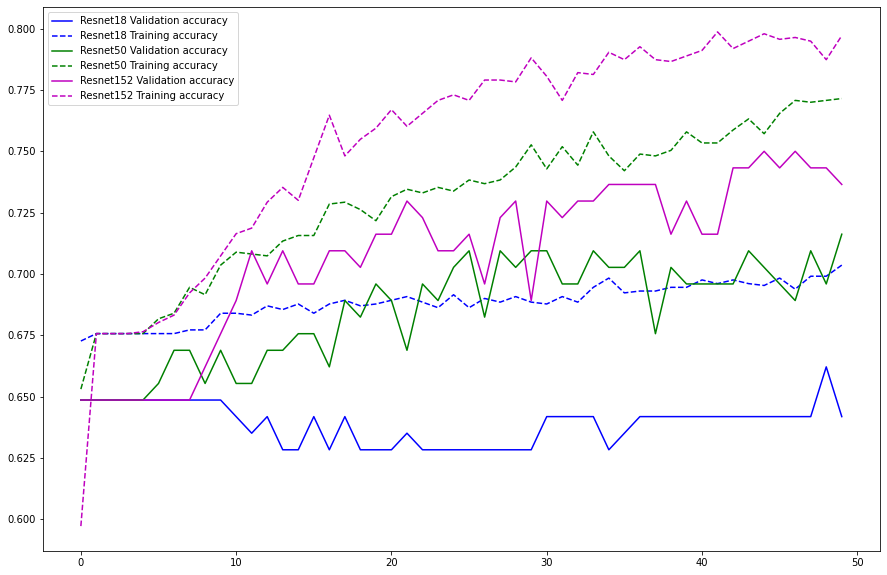

In [ ]:
# Plotting traning and validation performance

b_train_acc = []
for val in balanced_tr_hist:
  b_train_acc.append(val.cpu().data.numpy())

b_val_acc = []
for val in balanced_val_hist:
  b_val_acc.append(val.cpu().data.numpy())

b_train_acc2 = []
for val in balanced_tr_hist2:
  b_train_acc2.append(val.cpu().data.numpy())

b_val_acc2 = []
for val in balanced_val_hist2:
  b_val_acc2.append(val.cpu().data.numpy())

b_train_acc3 = []
for val in balanced_tr_hist3:
  b_train_acc3.append(val.cpu().data.numpy())

b_val_acc3 = []
for val in balanced_val_hist3:
  b_val_acc3.append(val.cpu().data.numpy())

# im_train_acc = []
# for val in imbalanced_tr_hist:
#   im_train_acc.append(val.cpu().data.numpy())

# im_val_acc = []
# for val in imbalanced_val_hist:
#   im_val_acc.append(val.cpu().data.numpy())
plt.figure(figsize=(15,10))
plt.plot(b_val_acc, 'b-', label='Resnet18 Validation accuracy')
plt.plot(b_train_acc,'b--', label='Resnet18 Training accuracy')
plt.plot(b_val_acc2, 'g-', label='Resnet50 Validation accuracy')
plt.plot(b_train_acc2,'g--', label='Resnet50 Training accuracy')
plt.plot(b_val_acc3, 'm-', label='Resnet152 Validation accuracy')
plt.plot(b_train_acc3,'m--', label='Resnet152 Training accuracy')
plt.legend()
plt.show()

In [ ]:
test_path_data = 'drive/MyDrive/balanced_csic_data_128/testing'
testing_dataset = torchvision.datasets.ImageFolder(test_path_data, transform=transform)
batch_size = 100
testing_dataloader =torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(testing_dataset.class_to_idx)


{'Cyperus': 0, 'Negative': 1, 'Portulaca': 2, 'Solanum': 3}


In [ ]:
def getTestingMatrics(dataloader, model):
  # send model to GPU
  if torch.cuda.is_available():
    model.cuda()

  # with tqdm(testing_dataloader) as tepoch:
  lbs = []
  preds = []
  #   # Iterate over data.
  for inputs, labels in dataloader:
    test_inputs = inputs.to(device)
    #test_labels = labels.to(device)
    outputs = model(test_inputs)
    _, pred = torch.max(outputs, 1)
    lbs+=(list(labels.numpy()))
    preds+= list(pred.cpu().data.numpy())
  print('Overall testing accuracy:',accuracy_score(lbs, preds))
  print(classification_report(lbs, preds, target_names=class_dict.keys()))

In [ ]:
getTestingMatrics(testing_dataloader, model_ft_balanced)
getTestingMatrics(testing_dataloader, model_ft_balanced2)
getTestingMatrics(testing_dataloader, model_ft_balanced3)


Overall testing accuracy: 0.3269230769230769
              precision    recall  f1-score   support

     Cyperus       0.28      1.00      0.44        40
    Negative       0.91      0.25      0.39        40
   Portulaca       0.00      0.00      0.00        40
     Solanum       0.25      0.03      0.05        36

    accuracy                           0.33       156
   macro avg       0.36      0.32      0.22       156
weighted avg       0.36      0.33      0.23       156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall testing accuracy: 0.3782051282051282
              precision    recall  f1-score   support

     Cyperus       0.31      1.00      0.47        40
    Negative       0.91      0.25      0.39        40
   Portulaca       1.00      0.07      0.14        40
     Solanum       0.46      0.17      0.24        36

    accuracy                           0.38       156
   macro avg       0.67      0.37      0.31       156
weighted avg       0.68      0.38      0.31       156

Overall testing accuracy: 0.33974358974358976
              precision    recall  f1-score   support

     Cyperus       0.30      0.97      0.46        40
    Negative       0.69      0.23      0.34        40
   Portulaca       0.00      0.00      0.00        40
     Solanum       0.36      0.14      0.20        36

    accuracy                           0.34       156
   macro avg       0.34      0.33      0.25       156
weighted avg       0.34      0.34      0.25       156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
